<a href="https://colab.research.google.com/github/HyunMiPark/study_AI/blob/main/%5B1%EC%A3%BC%EC%B0%A8%5D_%EC%8B%AC%ED%99%94%EA%B3%BC%EC%A0%9C_MNIST_ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- CIFAR-10 데이터셋을 이용하여 여러 신경망 모델 훈련
- SGD / Adam 옵티마이저, 활성화 함수(ReLU, Sigmoid), Dropout 적용 여부에 따른 학습 성능 차이 비교

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt


def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

In [3]:
#데이터셋 로딩(CIFAR-10)
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

100%|██████████| 170M/170M [00:03<00:00, 49.0MB/s]


In [5]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

In [6]:
from torch import nn

#LeakyReLU : 작은값을 유지, 기울기 소실문제(Vanishing Gradient)를 완화하는 효과
#ReLU : 음수 값을 0으로 만듬
class Model1(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x

In [7]:
# SGD(확률적 경사 하강법) : 단순한 기울기 기반 업데이트 -> 수렴 속도가 느릴 수 있음
from torch.optim import SGD, Adam

lr = 0.001

model = Model1(32 * 32 * 3, 1024)
model = model.to('cuda')

optimizer = SGD(model.parameters(), lr=lr)

n_epochs = 50
loss_fn = nn.CrossEntropyLoss()

train_sgd = []

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  train_sgd.append(accuracy(model, trainloader))

  print(f"Epoch {epoch + 1:3d} | Loss: {total_loss}")

Epoch   1 | Loss: 451.3142206668854
Epoch   2 | Loss: 450.7589888572693
Epoch   3 | Loss: 450.17997670173645
Epoch   4 | Loss: 449.62390065193176
Epoch   5 | Loss: 448.73684191703796
Epoch   6 | Loss: 447.77206444740295
Epoch   7 | Loss: 446.90073347091675
Epoch   8 | Loss: 446.0449757575989
Epoch   9 | Loss: 445.18803238868713
Epoch  10 | Loss: 444.2716679573059
Epoch  11 | Loss: 443.39410638809204
Epoch  12 | Loss: 442.47794127464294
Epoch  13 | Loss: 441.54499220848083
Epoch  14 | Loss: 440.5761218070984
Epoch  15 | Loss: 439.66264367103577
Epoch  16 | Loss: 438.6852161884308
Epoch  17 | Loss: 437.7396638393402
Epoch  18 | Loss: 436.81733417510986
Epoch  19 | Loss: 435.91391468048096
Epoch  20 | Loss: 435.0182144641876
Epoch  21 | Loss: 434.15086555480957
Epoch  22 | Loss: 433.34969449043274
Epoch  23 | Loss: 432.54061913490295
Epoch  24 | Loss: 431.7195580005646
Epoch  25 | Loss: 431.01500630378723
Epoch  26 | Loss: 430.20491194725037
Epoch  27 | Loss: 429.12476086616516
Epoch  28 

In [8]:
from torch.optim import Adam

# ADAM : 학습률을 자동 조정해 빠르게 수렴 가능
model = Model1(32 * 32 * 3, 1024)
model = model.to('cuda')

optimizer = Adam(model.parameters(), lr=lr)

train_adam = []
test_adam = []

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward() #기울기 계산
    optimizer.step() #가중치 업데이트

    total_loss += loss.item()

  train_adam.append(accuracy(model, trainloader))
  test_adam.append(accuracy(model, testloader))

  print(f"Epoch {epoch + 1:3d} | Loss: {total_loss}")

Epoch   1 | Loss: 422.4851830005646
Epoch   2 | Loss: 378.60381734371185
Epoch   3 | Loss: 357.7653912305832
Epoch   4 | Loss: 342.7963856458664
Epoch   5 | Loss: 331.89072251319885
Epoch   6 | Loss: 321.37467527389526
Epoch   7 | Loss: 313.5584205389023
Epoch   8 | Loss: 307.0436257123947
Epoch   9 | Loss: 300.2397507429123
Epoch  10 | Loss: 295.27877831459045
Epoch  11 | Loss: 289.7708908319473
Epoch  12 | Loss: 284.0208469629288
Epoch  13 | Loss: 280.13644099235535
Epoch  14 | Loss: 276.51952171325684
Epoch  15 | Loss: 272.34070801734924
Epoch  16 | Loss: 267.49226915836334
Epoch  17 | Loss: 264.1307156085968
Epoch  18 | Loss: 259.02687323093414
Epoch  19 | Loss: 257.47363328933716
Epoch  20 | Loss: 252.56691944599152
Epoch  21 | Loss: 251.01818120479584
Epoch  22 | Loss: 245.08542239665985
Epoch  23 | Loss: 242.72984719276428
Epoch  24 | Loss: 239.04570627212524
Epoch  25 | Loss: 237.57079076766968
Epoch  26 | Loss: 234.95506143569946
Epoch  27 | Loss: 229.33607757091522
Epoch  28 

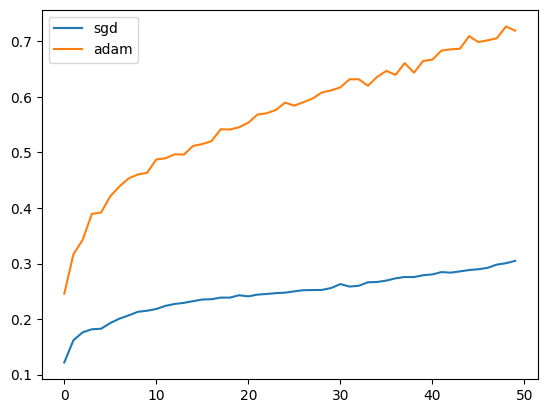

In [9]:
#SGD / Adam 수치 비교 : Adam이 빠르게 수렴하고 손실이 적음
plot_acc(train_sgd, train_adam, 'sgd', 'adam')

In [10]:
class Model2(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.Sigmoid() #Sigmoid 활성화 함수
    #출력값을 0~1로 제한 -> 다층 신경망에서는 기울기 소실 문제 발생 가능
    #ReLu 대비 학습 속도가 느리고 성능이 낮을 수 있음

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x

In [11]:
model = Model2(32 * 32 * 3, 1024)
model = model.to('cuda')

optimizer = Adam(model.parameters(), lr=lr)

train_sigmoid = []

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  train_sigmoid.append(accuracy(model, trainloader))

  print(f"Epoch {epoch + 1:3d} | Loss: {total_loss}")

Epoch   1 | Loss: 411.4123178720474
Epoch   2 | Loss: 393.3638446331024
Epoch   3 | Loss: 387.7136093378067
Epoch   4 | Loss: 384.1003520488739
Epoch   5 | Loss: 380.89664483070374
Epoch   6 | Loss: 379.79056322574615
Epoch   7 | Loss: 378.19191777706146
Epoch   8 | Loss: 376.4157272577286
Epoch   9 | Loss: 374.6582819223404
Epoch  10 | Loss: 374.0210738182068
Epoch  11 | Loss: 372.48255729675293
Epoch  12 | Loss: 370.83071744441986
Epoch  13 | Loss: 370.0696905851364
Epoch  14 | Loss: 369.3941205739975
Epoch  15 | Loss: 368.0105903148651
Epoch  16 | Loss: 367.0620583295822
Epoch  17 | Loss: 367.03617680072784
Epoch  18 | Loss: 365.95124554634094
Epoch  19 | Loss: 365.4056432247162
Epoch  20 | Loss: 364.66480803489685
Epoch  21 | Loss: 363.57769227027893
Epoch  22 | Loss: 363.67157220840454
Epoch  23 | Loss: 363.09338426589966
Epoch  24 | Loss: 363.22794675827026
Epoch  25 | Loss: 361.68880248069763
Epoch  26 | Loss: 361.6912463903427
Epoch  27 | Loss: 361.00252425670624
Epoch  28 | Lo

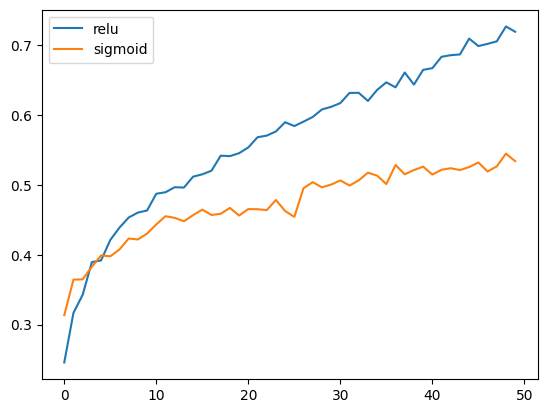

In [12]:
#ReLu / Sigmoid 비교 : ReLu가 성능이 더 좋음(Sigmoid는 기울기 소실 문제 발생)
plot_acc(train_adam, train_sigmoid, 'relu', 'sigmoid')

In [13]:
# Dropout

class Model3(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.LeakyReLU()
    self.dropout = nn.Dropout(p=0.1) #Dropout(10%) 적용
    #학습 중 랜덤하게 10%의 뉴런을 비활성화 -> 과적합 방지 효과

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.dropout(self.act(self.layer1(x)))
    x = self.dropout(self.act(self.layer2(x)))
    x = self.dropout(self.act(self.layer3(x)))

    return x

In [14]:
model = Model3(32 * 32 * 3, 1024)
model = model.to('cuda')

optimizer = Adam(model.parameters(), lr=lr)

train_dropout = []
test_dropout = []

for epoch in range(n_epochs):
  total_loss = 0.
  model.train() #Dropout 활성화(학습 중 일부 뉴런 비활성화)
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  with torch.no_grad():
    model.eval() #Dropout 비활성화(모든 뉴런 활성화, 평가 시 사용)
    train_dropout.append(accuracy(model, trainloader))
    test_dropout.append(accuracy(model, testloader))

  print(f"Epoch {epoch + 1:3d} | Loss: {total_loss}")

Epoch   1 | Loss: 439.24549436569214
Epoch   2 | Loss: 415.52725625038147
Epoch   3 | Loss: 406.4278771877289
Epoch   4 | Loss: 396.26446175575256
Epoch   5 | Loss: 386.8259166479111
Epoch   6 | Loss: 383.82958984375
Epoch   7 | Loss: 378.89705073833466
Epoch   8 | Loss: 375.4579224586487
Epoch   9 | Loss: 372.76012647151947
Epoch  10 | Loss: 366.9912431240082
Epoch  11 | Loss: 364.15721821784973
Epoch  12 | Loss: 359.62161672115326
Epoch  13 | Loss: 357.73368656635284
Epoch  14 | Loss: 355.1505957841873
Epoch  15 | Loss: 353.1620765924454
Epoch  16 | Loss: 350.1434768438339
Epoch  17 | Loss: 347.9048855304718
Epoch  18 | Loss: 347.09117591381073
Epoch  19 | Loss: 344.69053971767426
Epoch  20 | Loss: 343.232773065567
Epoch  21 | Loss: 342.8112407922745
Epoch  22 | Loss: 341.70651948451996
Epoch  23 | Loss: 339.71719431877136
Epoch  24 | Loss: 335.99242746829987
Epoch  25 | Loss: 334.7294931411743
Epoch  26 | Loss: 334.1421114206314
Epoch  27 | Loss: 332.74591398239136
Epoch  28 | Loss:

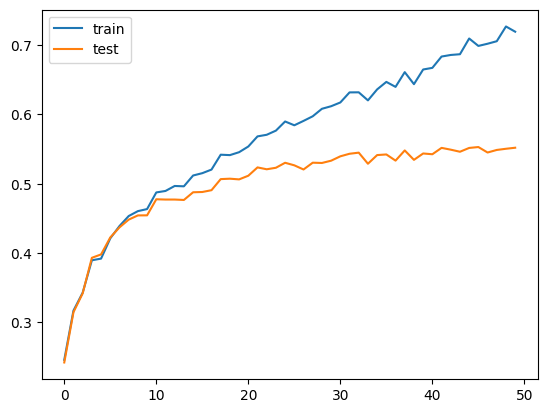

In [15]:
plot_acc(train_adam, test_adam)

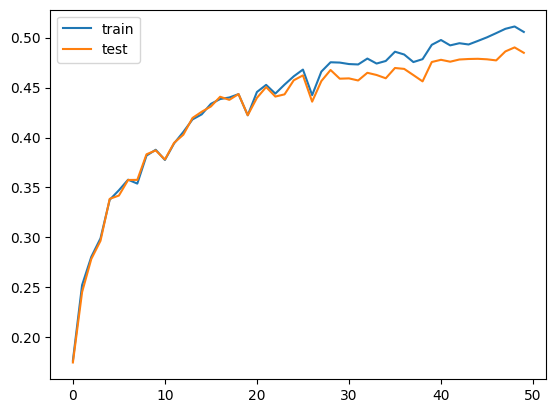

In [16]:
#Dropout 적용 여부 : Dropout을 사용하면 테스트 정확도가 더 높아짐(과적합 방지)
plot_acc(train_dropout, test_dropout)